# Silent Non Move Study

A silent non move occurs when a robot appears to have moved (i.e. has a normal entry in the moves DB) but in fact did not.

See [DESI-6765](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6765) for details.

In [1]:
%matplotlib inline

In [225]:
import json
import datetime

In [293]:
from pathlib import Path

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.colors

In [94]:
import astropy.time

In [7]:
import desietc.db

In [8]:
DESI = Path('/global/cfs/cdirs/desi')
if DESI.exists():
    DBCONFIG = DESI / 'engineering' / 'focalplane' / 'db.yaml'
    assert DBCONFIG.exists()
    DB = desietc.db.DB(config_name=DBCONFIG)
else:
    print(f'Not running at NERSC')

## Detection Algorithm

Detect silent non moves:

In [379]:
def timestamp_to_night(tutc, utc_offset=-7):
    
    tlocal = tutc + pd.Timedelta(utc_offset, 'hour')
    before_noon = tlocal.dt.hour < 12
    tlocal[before_noon] -= pd.Timedelta(1, 'day')
    return tlocal.dt.strftime('%Y%m%d')

In [443]:
def process(moves, min_move=5, max_stuck=15):
    
    # Sort by increasing time.
    moves.sort_values('time_recorded', inplace=True, ignore_index=True)
    
    # Verify that every row has valid angles POS_T,P and CTRL_ENABLED
    pos = moves.pos_t.notna() & moves.pos_p.notna()
    ctrl = moves.ctrl_enabled.notna()
    assert np.all(pos & ctrl)
    
    # Record angles of 2 previous moves.
    byloc = moves.groupby('location')
    moves['t_m1'] = byloc.pos_t.shift(+1, fill_value=np.nan)
    moves['t_m2'] = byloc.pos_t.shift(+2, fill_value=np.nan)
    moves['p_m1'] = byloc.pos_p.shift(+1, fill_value=np.nan)
    moves['p_m2'] = byloc.pos_p.shift(+2, fill_value=np.nan)

    # Record previous expid and iter.
    moves['expid'] = byloc.exposure_id.shift(+1, fill_value=-1)
    moves['iter'] = byloc.exposure_iter.shift(+1, fill_value=-1)
    
    # Look for FVC feedback updates where the corrected angle matches N-2.
    fvc = moves.log_note.str.contains('handle_fvc_feedback') & moves.ctrl_enabled
    F = moves[fvc].copy()
    # Convert a difference in theta angles to a physical angular separation in
    # the range [-180,180] or return NaN when dT is NaN.
    def wrapTheta(dT):
        wrapped = np.full_like(dT, np.nan)
        valid = np.isfinite(dT)
        wrapped[valid] = np.fmod(dT[valid] + 180, 360) - 180
        return wrapped
    # Compute the actual and requested physical changes in each angle.
    F['dtact'] = wrapTheta(F.pos_t - F.t_m2)
    F['dpact'] = F.pos_p - F.p_m2
    F['dtreq'] = wrapTheta(F.t_m1 - F.t_m2)
    F['dpreq'] = F.p_m1 - F.p_m2
    
    # Calculate night YYYYMMDD for each timestamp.
    F['night'] = timestamp_to_night(F.time_recorded)
    
    move_requested = np.hypot(F.dtreq, F.dpreq) >= min_move
    not_moved = np.hypot(F.dtact, F.dpact) < max_stuck
    print(f'{len(F)} {np.count_nonzero(move_requested)} {np.count_nonzero(move_requested & not_moved)}')
    
    return F[move_requested & not_moved][[
        'time_recorded','night','expid','iter','location','pos_id',
        'pos_t','t_m1','t_m2','pos_p','p_m1','p_m2',
        'dtreq','dpreq','dtact','dpact']]

Fetch moves covering a range of time stamps by querying the database. This should find the same rows as `process_night` below, but the returned dataframe will not be identical.  For example, float vs int dtype for the exposure_id column and rounding in the CSV file.

In [435]:
def process_range(start, stop):
    
    tables = []
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_moves_p{petal_id}'
        sql = f'''
            select time_recorded,pos_id,pos_t,pos_p,ctrl_enabled,exposure_id,exposure_iter,device_loc,log_note from {table_name}
             where (time_recorded > timestamp '{start}') and (time_recorded < timestamp '{stop}')'''
        table = DB.query(sql, maxrows=1000000)
        if len(table) > 0:
            print(f'Read {len(table)} rows for PETAL_LOC {petal_loc}')
        table['location'] = 1000*petal_loc + table['device_loc']
        table.drop(columns='device_loc', inplace=True)
        tables.append(table)
    moves = pd.concat(tables, axis='index', ignore_index=True)
    exps = moves.exposure_id.dropna().unique().astype(int)
    print(f'Found {len(exps)} exposures: {exps[0]} - {exps[-1]}')
    return process(moves)

Reconstruct moves from the end-of-night csv file, which is generally faster than querying the database:

In [92]:
def get_local_midnight(night):
    N = str(night)
    year, month, day = int(N[0:4]), int(N[4:6]), int(N[6:8])
    return astropy.time.Time(datetime.datetime(year, month, day, 12) + datetime.timedelta(hours=19))

In [362]:
def process_night(night):
    
    NIGHT = DESI / 'engineering' / 'focalplane' / 'endofnight' / str(night)
    if not NIGHT.exists():
        raise ValueError(f'No data found for {night}')
    moves_csv = NIGHT / f'moves-{night}.csv.gz'
    moves = pd.read_csv(moves_csv)
    
    # Uncompress the log note
    moves.log_note = (
        moves.log_note
        .str.replace("$F", "handle_fvc_feedback", regex=False))
    
    # Convert time_recorded from hours relative to noon_before back to timestamps
    midnight = get_local_midnight(night)
    twelve_hours = astropy.time.TimeDelta(12 * 3600, format='sec')
    noon_before = midnight - twelve_hours
    noon_ts = pd.Timestamp(str(noon_before) + '+0000')
    one_hr = pd.Timedelta(1, 'hour')
    moves['time_recorded'] = noon_ts + moves.time_recorded * one_hr
    
    return process(moves)

In [524]:
M = process_night(20220506)

57391 5768 32


In [528]:
M2 = final(M)

0


## Datasets

In [444]:
%time Mbefore = process_range('2022-03-13T02:30:00+0000', '2022-04-12T14:30:00+0000')

Read 909390 rows for PETAL_LOC 0
Read 878626 rows for PETAL_LOC 1
Read 881027 rows for PETAL_LOC 2
Read 891468 rows for PETAL_LOC 3
Read 879876 rows for PETAL_LOC 4
Read 876182 rows for PETAL_LOC 5
Read 901847 rows for PETAL_LOC 6
Read 876455 rows for PETAL_LOC 7
Read 949083 rows for PETAL_LOC 8
Read 894158 rows for PETAL_LOC 9
Found 904 exposures: 125929 - 126991
372318 208967 3235
CPU times: user 1min 37s, sys: 15 s, total: 1min 52s
Wall time: 2min 13s


In [445]:
%time Mduring = process_range('2022-04-14T02:30:00+0000', '2022-05-04T14:30:00+0000')

Read 736675 rows for PETAL_LOC 0
Read 707514 rows for PETAL_LOC 1
Read 713318 rows for PETAL_LOC 2
Read 714817 rows for PETAL_LOC 3
Read 708367 rows for PETAL_LOC 4
Read 707776 rows for PETAL_LOC 5
Read 726368 rows for PETAL_LOC 6
Read 702906 rows for PETAL_LOC 7
Read 757487 rows for PETAL_LOC 8
Read 722852 rows for PETAL_LOC 9
Found 616 exposures: 130091 - 133117
776382 156527 1038
CPU times: user 1min 23s, sys: 8.5 s, total: 1min 31s
Wall time: 1min 48s


In [447]:
%time Mafter = process_range('2022-05-05T02:30:00+0000', '2022-06-06T14:30:00+0000')

Read 68263 rows for PETAL_LOC 0
Read 65072 rows for PETAL_LOC 1
Read 65431 rows for PETAL_LOC 2
Read 65490 rows for PETAL_LOC 3
Read 65162 rows for PETAL_LOC 4
Read 64983 rows for PETAL_LOC 5
Read 66716 rows for PETAL_LOC 6
Read 64681 rows for PETAL_LOC 7
Read 71722 rows for PETAL_LOC 8
Read 66511 rows for PETAL_LOC 9
Found 59 exposures: 133256 - 133387
69323 16409 46
CPU times: user 9.08 s, sys: 515 ms, total: 9.6 s
Wall time: 11.7 s


## Plotting

In [342]:
def plotXY(data, value, agg=None, location='location',
           cmap='viridis', log=True, vmin=None, vmax=None, colorbar=True, labels=True, ax=None, save=False):

    if agg is not None:
        spatial = data.groupby(location)[value].agg(agg)
        locs = spatial.index
        z = spatial.to_numpy()
    else:
        locs = data[location]
        z = data[value]
    
    array = fpoffline.array.DeviceArray()
    x, y = array.xy()
    array[locs] = z
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10 if colorbar else 8, 8))

    Norm = matplotlib.colors.LogNorm if log else matplotlib.colors.Normalize
    
    ax.axis('off')
    ax.set_aspect(1)
    
    ax.scatter(x, y, lw=0, s=2, c='gray')
    S = ax.scatter(x, y, lw=0, s=25, c=array.data, norm=Norm(vmin=vmin, vmax=vmax), cmap=cmap)
    
    if colorbar is not False:
        label = colorbar if isinstance(colorbar, str) else None
        plt.colorbar(S, ax=ax, shrink=0.8, pad=0, label=label)
    
    if save is not False:
        save = save if isinstance(save, str) else 'plotXY.jpg'
        plt.tight_layout()
        plt.savefig(save)

## Analysis

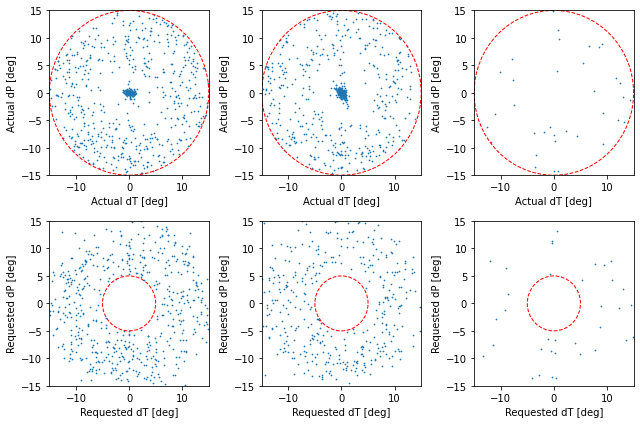

In [458]:
def plot_deltas(it):
    
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))
    
    for col, data in enumerate((Mbefore, Mduring, Mafter)):
        data = data[data.iter == it]
        axes[0, col].scatter(data.dtact, data.dpact, lw=0, s=3)
        axes[0, col].set(xlim=(-15,15), ylim=(-15,15), xlabel='Actual dT [deg]', ylabel='Actual dP [deg]')
        axes[0, col].add_artist(plt.Circle((0,0), 15, ls='--', ec='r', fc='none'))
        axes[1, col].scatter(data.dtreq, data.dpreq, lw=0, s=3)
        axes[1, col].set(xlim=(-15,15), ylim=(-15,15), xlabel='Requested dT [deg]', ylabel='Requested dP [deg]')
        axes[1, col].add_artist(plt.Circle((0,0), 5, ls='--', ec='r', fc='none'))
        
    plt.tight_layout()
    plt.savefig(f'deltas-iter{it}.jpg')
    
plot_deltas(it=0)

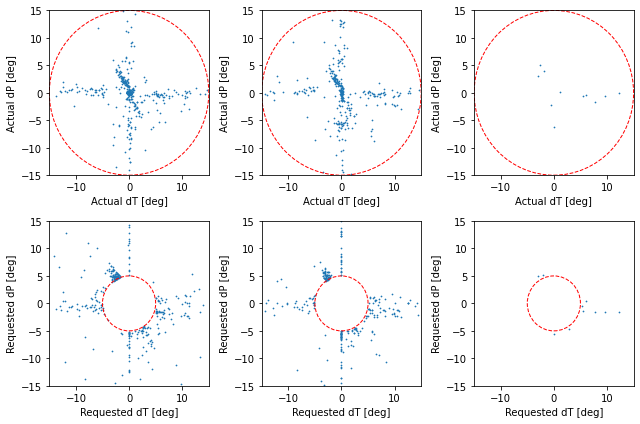

In [459]:
plot_deltas(it=1)

In [480]:
def plot_xy(data, **kwargs):
    
    sel = (data.iter == 0) & (np.hypot(data.dtreq, data.dpreq) > 5) & (np.hypot(data.dtact, data.dpact) < 2)
    print(np.count_nonzero(sel))
    plotXY(data[sel], 'location', 'count', colorbar='Number of silent non moves', **kwargs)

1181


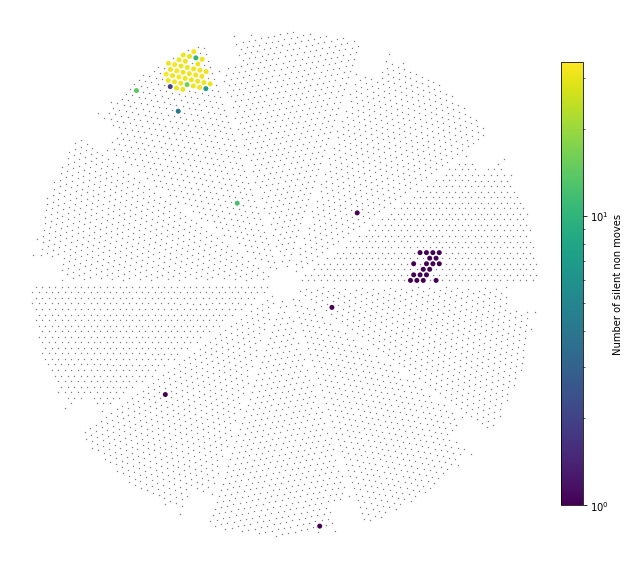

In [482]:
plot_xy(Mbefore, save='before.jpg')

276


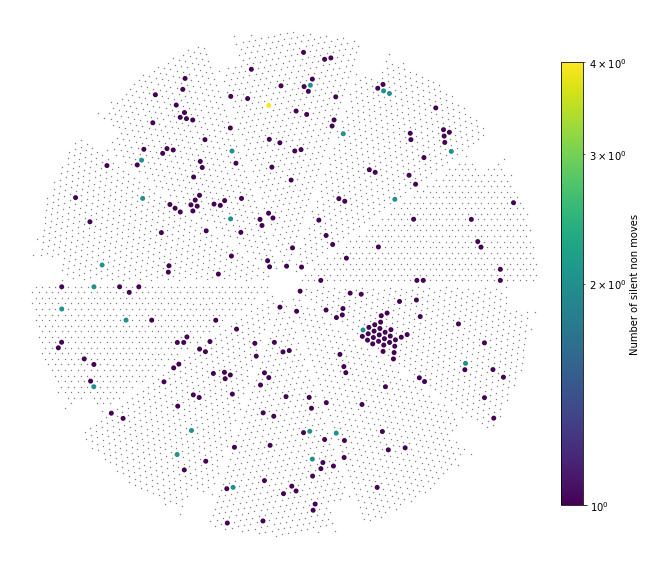

In [481]:
plot_xy(Mduring, save='during.jpg')

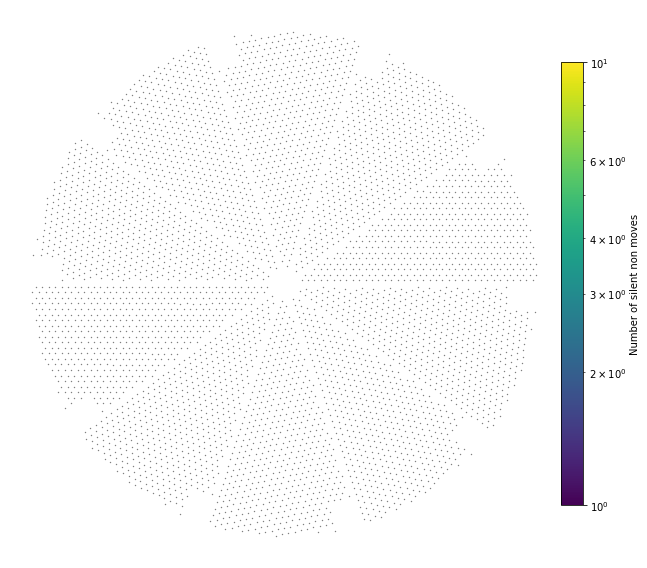

In [479]:
plot_xy(Mafter, save='after.jpg', vmin=1, vmax=10)

22


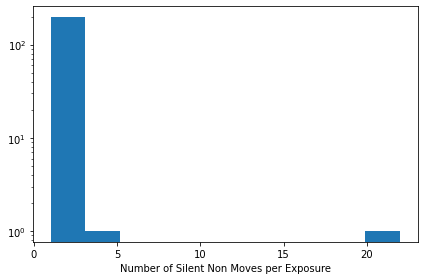

In [504]:
def plot_mult(data, save):
    sel = (data.iter == 0) & (np.hypot(data.dtreq, data.dpreq) > 5) & (np.hypot(data.dtact, data.dpact) < 2)
    multiplicity = data[sel].groupby('expid').expid.count()
    print(multiplicity.max())
    #bins=np.linspace(0.5, 19.5, 20)
    #print(bins)
    plt.hist(multiplicity)#, bins=bins)
    #plt.xlim(bins[0], bins[-1])
    #plt.xticks(np.arange(1, 20))
    plt.yscale('log')
    plt.xlabel('Number of Silent Non Moves per Exposure')
    plt.tight_layout()
    plt.savefig(save)
    
plot_mult(Mduring, 'during-mult.jpg')

42


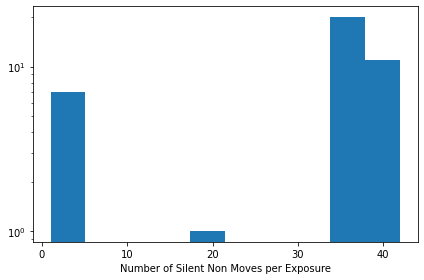

In [505]:
plot_mult(Mbefore, 'before-mult.jpg')

254


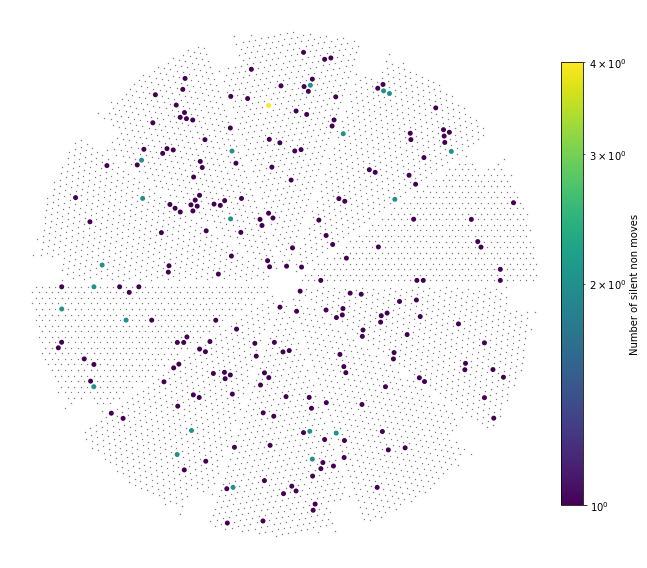

In [527]:
def final(data, max_mult=5, save=None, csv=None):
    
    sel = (data.iter == 0) & (np.hypot(data.dtreq, data.dpreq) > 5) & (np.hypot(data.dtact, data.dpact) < 2)
    data = data[sel]
    multiplicity = data.groupby('expid').expid.count()
    isolated = multiplicity < max_mult
    use_expids = multiplicity.index[isolated]
    sel = np.isin(data.expid, use_expids)
    data = data[sel]
    print(len(data))
    if len(data) > 0:
        plotXY(data, 'location', 'count', colorbar='Number of silent non moves', save=save)
        if csv is not None:
            data.to_csv(csv, index=False)
    return data
    
isoduring = final(Mduring, save='isolated-during.jpg', csv='isolated-during.csv')

5


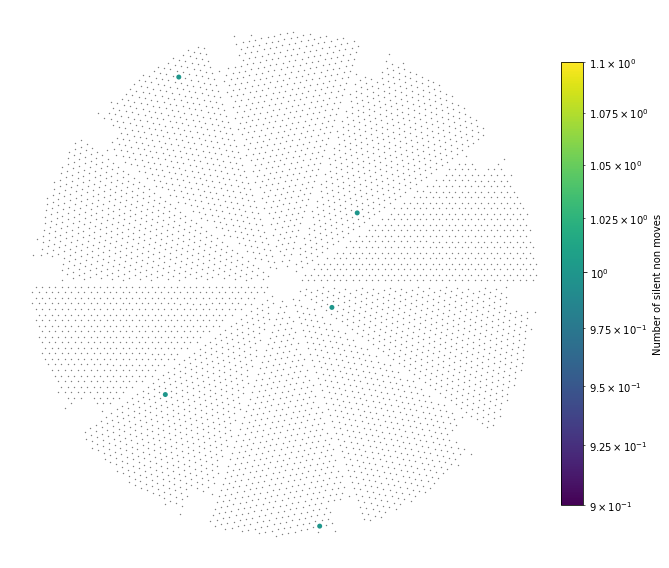

In [516]:
isobefore = final(Mbefore, save='isolated-before.jpg', csv='isolated-before.csv')

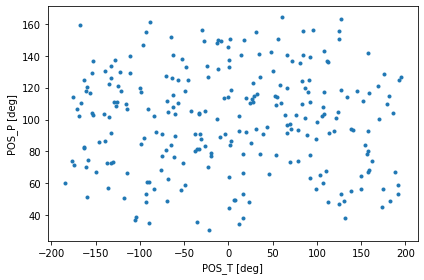

In [522]:
def plot_angles():
    plt.plot(isoduring.pos_t, isoduring.pos_p, '.')
    plt.xlabel('POS_T [deg]')
    plt.ylabel('POS_P [deg]')
    plt.tight_layout()
    plt.savefig('angles.jpg')
    
plot_angles()

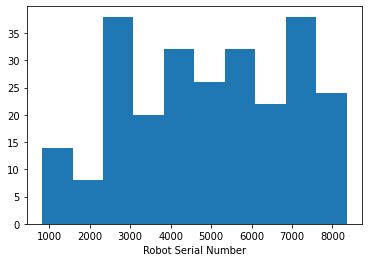

In [523]:
def plot_sernum():
    plt.hist(isoduring.pos_id.str.slice(2).astype(int))
    plt.xlabel('Robot Serial Number')
    plt.savefig('sernum.jpg')
    
plot_sernum()